Read data

In [27]:
#import nvidia.cudnn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Shape x_train:
(50000, 32, 32, 3)

Number of dimensions:
4

Datatypes:
uint8

Shape x_test:
(10000, 32, 32, 3)


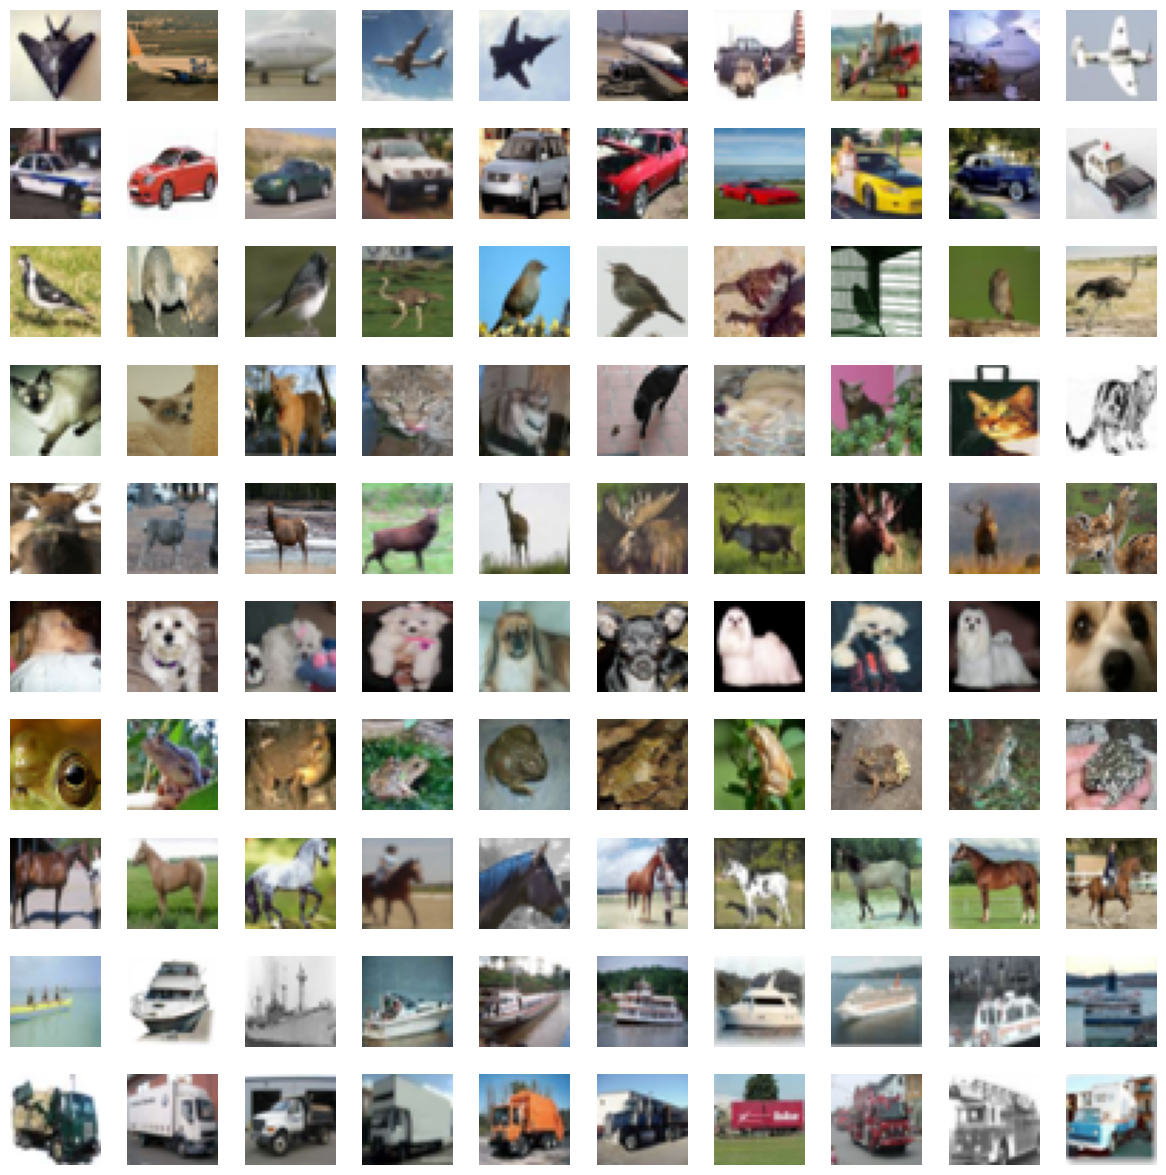

After reshaping:
(50000, 32, 32, 3, 1)
5
float32
(10000, 32, 32, 3, 1)
(50000, 10)
(10000, 10)


In [28]:
print("Shape x_train:")
print(x_train.shape)
print()
print("Number of dimensions:")
print(x_train.ndim)
print()
print("Datatypes:")
print(x_train.dtype)
print()
print("Shape x_test:")
print(x_test.shape)


## Visualisize images
# read call lables
class_names = np.unique(y_train)

# Set up the figure for a 10x10 plot
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for i in range(10):
    # Get indices for images of class i
    indices = np.where(y_train == i)[0]
    # Randomly select 10 indices from the class
    random_indices = np.random.choice(indices, size=10, replace=False)
    
    for j, idx in enumerate(random_indices):
        # Plot the image in the appropriate subplot
        axes[i, j].imshow(x_train[idx])
        axes[i, j].axis('off')  # Hide axis ticks
        if j == 0:
            axes[i, j].set_ylabel(class_names[i], fontsize=12)  # Label the class

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

# converts the data type of the x_train array to float32
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print('After reshaping:')

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(x_train.shape)
print(x_train.ndim)
print(x_train.dtype)
print(x_test.shape)

# converts target to categorical data
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

In [29]:
from keras.backend import clear_session
clear_session()

In [30]:
# init model
vgg_model = Sequential()

# add Convolutional-Layer 
vgg_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
vgg_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# add MaxPooling-Layer
vgg_model.add(MaxPooling2D((2, 2), padding='same'))

# add 2 more Convolutional-Layer 
vgg_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# improve training speed and stability
vgg_model.add(BatchNormalization())


# add MaxPooling-Layer
vgg_model.add(MaxPooling2D((2, 2), padding='same'))

# Flatten output
vgg_model.add(Flatten())

# add Dense-Layer with 128 units
vgg_model.add(Dense(128, activation='relu'))

# add dropout after dense-layer to  prevent overfitting
vgg_model.add(Dropout(0.5))

# add classification layer (10 classes)
vgg_model.add(Dense(10, activation='softmax'))

# model summary
vgg_model.summary()

/home/georg/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,310,666 (5.00 MB)

 Trainable params: 1,310,410 (5.00 MB)

 Non-trainable params: 256 (1.00 KB)

In [31]:
# train settings
batch_size = 512
num_classes = 10
epochs = 45


adam_opt = Adam(learning_rate=0.001)


# compile the model
vgg_model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

# train model
history_m3 = vgg_model.fit(x_train, y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))


# predict output for test data
predictions = vgg_model.predict(x_test)

print(predictions.shape)
predictions = np.argmax(predictions, axis=1)

# print confusion matrix
gt = np.argmax(y_test, axis=1)
confusion_matrix(gt, predictions)

Epoch 1/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.4221 - loss: 1.6194 - val_accuracy: 0.1610 - val_loss: 2.1251
Epoch 2/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5917 - loss: 1.1590 - val_accuracy: 0.4050 - val_loss: 1.8964
Epoch 3/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6703 - loss: 0.9410 - val_accuracy: 0.4439 - val_loss: 1.6626
Epoch 4/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7125 - loss: 0.8251 - val_accuracy: 0.6695 - val_loss: 1.2037
Epoch 5/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7404 - loss: 0.7368 - val_accuracy: 0.7052 - val_loss: 0.9675
Epoch 6/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7677 - loss: 0.6655 - val_accuracy: 0.7268 - val_loss: 0.8084
Epoch 7/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7915 - loss: 0.5949 - val_accuracy: 0.7579 - val_loss: 0.6993
Epoch 8/45
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8103 - loss: 0.5391 - val_accuracy: 0.7720 - 

array([[798,  11,  27,  25,  13,   7,   4,   6,  61,  48],
       [ 14, 850,   1,   7,   0,   8,   2,   1,  17, 100],
       [ 62,   3, 612,  77,  81,  87,  30,  26,  12,  10],
       [  8,   3,  37, 634,  45, 199,  26,  22,   9,  17],
       [  7,   2,  30,  72, 788,  31,   7,  48,  12,   3],
       [  8,   2,  17, 149,  27, 748,   6,  31,   4,   8],
       [  7,   6,  46,  96,  50,  38, 735,   6,  11,   5],
       [  9,   1,   8,  48,  33,  71,   1, 817,   3,   9],
       [ 34,  14,   4,  12,   4,   4,   1,   5, 888,  34],
       [ 16,  25,   2,  12,   1,   2,   1,   9,  15, 917]])

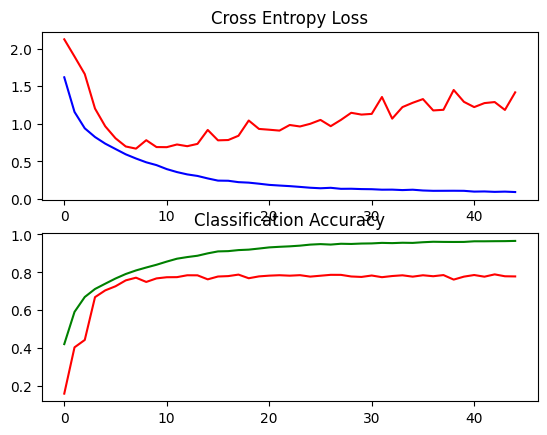

In [32]:
# plot entropy loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history_m3.history['loss'], color='blue', label='train')
plt.plot(history_m3.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history_m3.history['accuracy'], color='green', label='train')
plt.plot(history_m3.history['val_accuracy'], color='red', label='val')
plt.show()

In [33]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = vgg_model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy:.3f}')
print(f'Test loss: {test_loss:.3f}')  

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7787 - loss: 1.4195
Test Accuracy: 0.779
Test loss: 1.419
